
<h1 align = "center"> Plus Size Marketing and Purchase Intent  </h1>
<h2 align = "center"><em> Haley Farber, Brandon Scolieri, Candice Sener, Anjali Unnithan, Derrick Xiong</em></h2> 
<h4 align = "center"> W241: Experiments and Causality </h4>
<h4 align = "center"> April, Spring 2021 </h4> 

# Abstract


The modeling industry has experienced tremendous changes within the past decade regarding more diverse representations of models based on gender, race, and body type. Our goal of this project was to determine if the inclusion and increased visibility of plus-size models would cause women to be more likely to purchase clothing. Essentially, does the exposure of plus-size models in certain clothing garments increase or decrease purchase intent of those clothing garments on average? 

To help solve this question, we created a survey in which each participant was shown twenty images of models wearing particular garments and asked to rate their likeliness of purchasing the advertised item. We administered two versions of a survey on Mechanical Turk, one with plus-size models and one with model sizes most represented in the modeling industry (i.e. US womens’ sizes 0-4). We were interested in determining whether or not someone would give a different purchase intent score when viewing a model that resembled the average size of a female U.S. shopper versus viewing a model that resembled the average size of a female U.S. model, which is a U.S. women’s size 0-4. 

As part of our experimentation we also investigated whether different levels of self-esteem have an impact on purchase intent. As is elaborated on in our results section, we found no significant difference in average purchase intent between the treatment and control groups overall. However, we did discover some differences between the control and treatment group’s responses as it relates to self-esteem, but no statistically significant results or differences across various body sizes. 


# Imports

In [ ]:
######################
# INSTALLS & IMPORTS #
######################

install.packages("tidyverse", repos = "http://cran.rstudio.com/")
install.packages('data.table', repos = "http://cran.rstudio.com/") 
install.packages("matrixStats", repos = "http://cran.rstudio.com/")
install.packages("vtable",repos = "http://cran.rstudio.com/") 
install.packages("sandwich",repos = "http://cran.rstudio.com/") 
install.packages("lmtest",repos = "http://cran.rstudio.com/")  
install.packages("stargazer",repos = "http://cran.rstudio.com/") 
install.packages("pwr",repos = "http://cran.rstudio.com/")
install.packages("vcd",repos = "http://cran.rstudio.com/")

library(tidyverse)
library(data.table)
library(matrixStats)
library(vtable)
library(sandwich)
library(lmtest)
library(stargazer)
library(pwr)
library(vcd)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘data.table’, ‘gargle’, ‘ids’, ‘dbplyr’, ‘dtplyr’, ‘googledrive’, ‘googlesheets4’, ‘pillar’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘webshot’, ‘insight’, ‘kableExtra’, ‘sjlabelled’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

War

ERROR: ignored

# Data

In [ ]:
############
# RAW DATA #
############

survey_data = read_csv("./sample_data/W241_final_dataset.csv")
# survey_data = read_csv("./sample_data/w241_frozen_final_dataset.csv")

# Converting data into a data table object
df <- data.table(survey_data)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  StartDate = col_character(),
  EndDate = col_character(),
  Status = col_character(),
  IPAddress = col_character(),
  Finished = col_logical(),
  RecordedDate = col_character(),
  ResponseId = col_character(),
  DistributionChannel = col_character(),
  UserLanguage = col_character(),
  age = col_character(),
  race = col_character(),
  self_esteem_rate = col_character(),
  shopping_style = col_character(),
  shop_online = col_character(),
  shopping_preferences = col_character(),
  size_free_response = col_character(),
  shopping_explore_time = col_character(),
  shopping_montly_amount = col_character(),
  shopping_exp_description = col_character(),
  size_bucket = col_character()
  # ... with 42 more columns
)
ℹ Use `spec()` for the full column specifications.




In [ ]:
##############
# INSPECTION #
##############

# spec(survey_data)
#class(df)

# Helper Functions

In [ ]:
####################
# HELPER FUNCTIONS #
####################

to_categorical <- function(column) {
  #' This function converts likert scale questions to integers of respective value.
  factors <- as.numeric(factor(column,
                  # specifify the levels in the correct order:
                  levels=c("Extremely unlikely", "Somewhat unlikely", "Neither likely nor unlikely", "Somewhat likely", "Extremely likely")))
                  
  return(factors)
}


drop_columns <- function(df) {
  #` This function drops the columns specified within the function from a specified df.
  return (
    subset(
      df,
      select = -c(Progress, `Duration (in seconds)`, Status, IPAddress, Finished, StartDate, EndDate, RecordedDate, LocationLatitude, LocationLongitude, DistributionChannel, UserLanguage)
    ))
}


map_to_condensed_variables <- function(dt) {
  #condense race variable 
  dt[!race %in% c("White","Asian","Hispanic or Latino","Black or African American","American Indian or Alaska Native"),race:= "Mixed/Other"]

  #condense size bucket 
  dt[size_bucket %in% c("18-24","26+"),size_bucket := "18+"]

  #condense size bucket further, via condensing to either, above, below, or at the mode of the size bucket responses.
  dt[,size_bucket_condensed := fcase(
                          size_bucket == "0-4", "Below Modal Size",
                          size_bucket == "6-10", "Modal Size",
                          size_bucket %in% c("12-16","18+"), "Above Modal Size"
                          )]

  #condense size bucket even further to a binary variable, via condensing to either, above or below the mode of the size bucket responses.
  dt[,size_bucket_condensed_binary := fcase(
                            size_bucket %in% c("0-4","6-10"), "Modal and Below Modal Size",
                            size_bucket %in% c("12-16","18+"), "Above Modal Size"
                            )]

  #condense self esteem rate questions 
  dt[,self_esteem_rate := fcase(
                          self_esteem_rate %in% c("Somewhat high","Very high"), "High",
                          self_esteem_rate %in% c("Somewhat low","Very low"), "Low",
                          self_esteem_rate == "Neutral", "Neutral"
                          )]

  #condense shopping style questions 
  dt[,shopping_style:= fcase(
                        shopping_style == "I shop once a month or less","shop less than once per month",
                        shopping_style == "I shop 2-4 times a month", "shop 2-4 times per month",
                        shopping_style %in% c("I shop 5-10 times a month","I shop more than 10 times a month"), "shop 5+ times per month"
                        )]

  #condense shop online questions 
  dt[,shop_online := fcase(
                          shop_online %in% c("I only shop online","I usually shop online"), "mostly online",
                          shop_online %in% c("I occasionally shop online","I never shop online"), "mostly in person",
                          shop_online == "It’s about equal, I shop online and in person", "about equal"
                          )]

  #condense shopping_preferences 
  dt[,shopping_preferences := fcase(
                          shopping_preferences %in% c("I know exactly what I need and spend little time browsing before making a purchase",
                          "I don’t browse for pleasure"), "low browsing",
                          shopping_preferences == "I browse until I find what I need and then make a purchase", "medium browsing",
                          shopping_preferences %in% c("I spend the majority of my time browsing before making a purchase",
                          "I often browse products without making a purchase"), "high browsing"
                          )]
                          
  #condense shopping_exp_description
  dt[,shopping_exp_description := fcase(
                          shopping_exp_description %in% c("I am always satisfied by the fit of my garment",
                          "I am usually satisfied by the fit of my garment"), "usually satisfied",
                          shopping_exp_description == "Sometimes it fits, sometimes it doesn’t", "sometimes satisfied",
                          shopping_exp_description %in% c("I am always frustrated with the size of my garment",
                          "I am usually frustrated with the size of my garment"), "usually frustrated"
                          )]

  #condense size purchase confidence questions 
  dt[,size_purchase_confidence := fcase(
                          size_purchase_confidence %in% c("I am certain, I always order the right size","I am very confident, I usually order the right size"), "confident",
                          size_purchase_confidence == "I’m not sure", "sometimes confident",
                          size_purchase_confidence %in% c("I have no confidence in the fit, I always need to order a different size after the first purchase",
                          "I am not very confident, I often order the wrong size"), "not confident"
                          )]
  return(dt)

}


riTest <- function(tbl, reps) {
  riArray <- rep(NA, reps)
  for (ri in 1:reps) {
    riArray[ri] <- tbl[, .(mean_purchase_intent = mean(purchase_treat)),
                       keyby = .(sample(treated))][, diff(mean_purchase_intent)]
  }
  return(riArray)
}



# Data Cleaning

In [ ]:
############
# CLEANING #
############

#Dropping Extraneous Columns
master_df <- drop_columns(df)

## Inspecting
# head(master_df)
# columnnames(master_df)

# Transformations

In [ ]:
###########################
# FEATURE TRANSFORMATIONS #
###########################

# In this cell we are subsetting the columns that will be transformed into our outcome variables.

# Purchase Intent Outcome Vars
t_purchase_columns <- c("t1","t2","t3","t4","t5","t6","t7","t8","t9","t10","t11","t12","t13","t14","t15","t16","t17","t18","t19","t20")
c_purchase_columns <- c("c1","c2","c3","c4","c5","c6","c7","c8","c9","c10","c11","c12","c13","c14","c15","c16","c17","c18","c19","c20")
all_purchases <- c(t_purchase_columns,c_purchase_columns)

# Click Count Outcome Vars
t_click_count_columns <- c("t1_click_count","t2_click_count","t3_click_count","t4_click_count","t5_click_count","t6_click_count","t7_click_count","t8_click_count","t9_click_count","t10_click_count","t11_click_count","t12_click_count","t13_click_count","t14_click_count","t15_click_count","t16_click_count","t17_click_count","t18_click_count","t19_click_count","t20_click_count")
c_click_count_columns <- c("c1_click_count","c2_click_count","c3_click_count","c4_click_count","c5_click_count","c6_click_count","c7_click_count","c8_click_count","c9_click_count","c10_click_count","c11_click_count","c12_click_count","c13_click_count","c14_click_count","c15_click_count","c16_click_count","c17_click_count","c18_click_count","c19_click_count","c20_click_count")
all_click_counts <- c(t_click_count_columns,c_click_count_columns)

#Page Submit Outcome Vars
t_page_submits <- c("t1_page_submit","t2_page_submit","t3_page_submit","t4_page_submit","t5_page_submit","t6_page_submit","t7_page_submit",
"t8_page_submit","t9_page_submit","t10_page_submit","t11_page_submit","t12_page_submit","t13_page_submit","t14_page_submit","t15_page_submit",
"t16_page_submit","t17_page_submit","t18_page_submit","t19_page_submit","t20_page_submit")
c_page_submits <- c("c1_page_submit","c2_page_submit","c3_page_submit","c4_page_submit","c5_page_submit","c6_page_submit","c7_page_submit",
"c8_page_submit","c9_page_submit","c10_page_submit","c11_page_submit","c12_page_submit","c13_page_submit","c14_page_submit","c15_page_submit",
"c16_page_submit","c17_page_submit","c18_page_submit","c19_page_submit","c20_page_submit")
all_page_submits <- c(t_page_submits,c_page_submits)


#all_click_counts
#all_purchases

In [ ]:
###########################
# FEATURE TRANSFORMATIONS #
###########################

# In this cell we are mapping likert scale values to integers, creating the treatment column, and computing aggregate statistics for our outcome variables.

#Creating integers for likert purchasing questions
master_df[, (all_purchases):= lapply(.SD, to_categorical),.SDcols = all_purchases]

#Adding the treated column (treatment = 1, control = 0)
master_df[,treated:= ifelse(is.na(c1), 1, 0)]

#Computing the row means for the treatment questions (model photo questions)
master_df[treated == 1, purchase_treat:= rowMeans(.SD), .SDcols = t_purchase_columns]
master_df[treated == 0, purchase_treat:= rowMeans(.SD), .SDcols = c_purchase_columns]

#Computing the row means for our secondary outcome measure (comparing click count averages between the treatment and control groups)
master_df[treated == 1, click_count_mean:= rowMeans(.SD), .SDcols = t_click_count_columns]
master_df[treated == 0, click_count_mean:= rowMeans(.SD), .SDcols = c_click_count_columns]

#Computing the row medians for our secondary outcome measure (comparing page submit medians between the treatment and control groups)
master_df[treated == 1, page_submit_treat:= rowMedians(as.matrix(.SD)), .SDcols = t_page_submits]
master_df[treated == 0, page_submit_treat:= rowMedians(as.matrix(.SD)), .SDcols = c_page_submits]

#Inspecting
# head(master_df)

# Covariate Balance Inspection

In [ ]:
######################################
# COVARIATE BALANCE CHECK (GRANULAR) #
######################################

#Clean the master data table by pulling only columns necessary for covariate balance check and regressions
clean_dt <- master_df[,c(1:12,213:219)]

#Create a table of covariates to simplify covariate balance check. Note: size free response is omitted - a separate analysis will be performed unless deleted.
covariates_granular <- clean_dt[,c(2:7,9:14,16)]

#Create Covariance Balance Table
covariance_balance_table_granular <- sumtable(covariates_granular, group = "treated", group.test = TRUE, out = "return")

covariance_balance_table_granular

Variable,N,Percent,N,Percent,Test
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
treated,0,,1,,
age,76,,75,,X2=1.25
... 18 -29 years,15,19.7%,13,17.3%,
... 30-39 years,25,32.9%,23,30.7%,
... 40-49 years,13,17.1%,13,17.3%,
... 50-59 years,17,22.4%,16,21.3%,
... 60+ years,6,7.9%,10,13.3%,
self_esteem_rate,76,,75,,X2=2.056
... Neutral,22,28.9%,23,30.7%,


In [ ]:
#######################################
# COVARIATE BALANCE CHECK (CONDENSED) #
#######################################

#Reduce Covariate Dimensionality
clean_dt <- map_to_condensed_variables(clean_dt)

#Create Condensed Covariates Table
#Note: During dimensionality reduction, two new columns named, "size_bucket_condensed" and "size_bucket_condensed_binary" are added. 
#The "size_bucket_condensed" column is representative of condensing the original "size_bucket" column to either, above, below, or at the mode of the size bucket responses.
#The "size_bucket_condensed_binary" column is representative of condensing the original "size_bucket" column to a binary variable that is either, above or below the mode of the size bucket responses.

covariates_condensed <- clean_dt[,c(2:7, 11:12, 20, 21, 13:14, 16)]

#Create Covariance Balance Table
covariate_balance_table_condensed <- sumtable(covariates_condensed, group = "treated", group.test = TRUE, out = "return")

covariate_balance_table_condensed

Variable,N,Percent,N,Percent,Test
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
treated,0,,1,,
age,76,,75,,X2=1.25
... 18 -29 years,15,19.7%,13,17.3%,
... 30-39 years,25,32.9%,23,30.7%,
... 40-49 years,13,17.1%,13,17.3%,
... 50-59 years,17,22.4%,16,21.3%,
... 60+ years,6,7.9%,10,13.3%,
race,76,,75,,X2=3.422
... Asian,7,9.2%,9,12%,


# Modeling

In [ ]:
#######################################
# MODEL 1 (BASELINE REGRESSION MODEL) #
#######################################

basic_model <- clean_dt[,lm(purchase_treat ~ treated)]
basic_model$vcovHC_ <- vcovHC(basic_model)
coeftest(basic_model, vcov. = basic_model$vcovHC_)


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.60066    0.11619 22.3829   <2e-16 ***
treated     -0.15932    0.16638 -0.9576   0.3398    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
###########
# MODEL 2 #
###########

model_2 <- clean_dt[,lm(purchase_treat ~ treated + size_bucket + (treated * size_bucket))]
model_2$vcovHC_ <- vcovHC(model_2)
coeftest(model_2, vcov. = model_2$vcovHC_)


t test of coefficients:

                         Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               2.45357    0.26466  9.2708 2.612e-16 ***
treated                  -0.39588    0.37361 -1.0596    0.2911    
size_bucket12-16          0.11222    0.33571  0.3343    0.7387    
size_bucket18+           -0.13357    0.43666 -0.3059    0.7601    
size_bucket6-10           0.31461    0.32804  0.9591    0.3391    
treated:size_bucket12-16  0.41898    0.48366  0.8663    0.3878    
treated:size_bucket18+    0.46088    0.65605  0.7025    0.4835    
treated:size_bucket6-10   0.15417    0.45883  0.3360    0.7374    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
##########################################
# SECONDARY MODEL (PAGE SUBMIT DURATION) #
##########################################

#Run a basic regression on secondary outcome time to get started 
secondary_model <- clean_dt[,lm(page_submit_treat ~ treated)]
secondary_model$vcovHC_ <- vcovHC(secondary_model)
coeftest(secondary_model, vcov. = secondary_model$vcovHC_)


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.713789   0.201435 18.4367   <2e-16 ***
treated     0.040911   0.259253  0.1578   0.8748    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
#################################
# SECONDARY MODEL (CLICK COUNT) #
#################################

#Run a basic regression on secondary outcome clicks to get started 
secondary_model_clicks <- clean_dt[,lm(click_count_mean ~ treated)]
secondary_model_clicks$vcovHC_ <- vcovHC(secondary_model_clicks)
coeftest(secondary_model_clicks, vcov. = secondary_model_clicks$vcovHC_)


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.51711    0.12929 11.7341   <2e-16 ***
treated      0.12556    0.18260  0.6876   0.4928    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
#################################
# SECONDARY MODEL (SELF-ESTEEM) #
#################################

self_model <- clean_dt[, lm(purchase_treat ~ treated + as.factor(self_esteem_rate) + treated * as.factor(self_esteem_rate))]
self_model$vcovHC_ <- vcovHC(self_model)
coeftest(self_model, vcov. = self_model$vcovHC_)


t test of coefficients:

                                           Estimate Std. Error t value
(Intercept)                                 3.09063    0.18784 16.4536
treated                                    -0.42004    0.26357 -1.5936
as.factor(self_esteem_rate)Low             -0.69290    0.26879 -2.5778
as.factor(self_esteem_rate)Neutral         -0.99972    0.24736 -4.0416
treated:as.factor(self_esteem_rate)Low      0.35842    0.40235  0.8908
treated:as.factor(self_esteem_rate)Neutral  0.51391    0.37224  1.3806
                                            Pr(>|t|)    
(Intercept)                                < 2.2e-16 ***
treated                                      0.11320    
as.factor(self_esteem_rate)Low               0.01094 *  
as.factor(self_esteem_rate)Neutral         8.584e-05 ***
treated:as.factor(self_esteem_rate)Low       0.37450    
treated:as.factor(self_esteem_rate)Neutral   0.16953    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
###########################################
# SECONDARY MODEL (MODAL SIZES CONDENSED) #
###########################################

#Regression model with modal sizes 

condensed_size_model <- clean_dt[, lm(purchase_treat ~ treated + as.factor(size_bucket_condensed) + treated * as.factor(size_bucket_condensed))]
condensed_size_model$vcovHC_ <- vcovHC(condensed_size_model)
coeftest(condensed_size_model, vcov. = condensed_size_model$vcovHC_)


t test of coefficients:

                                                          Estimate Std. Error
(Intercept)                                               2.481034   0.174916
treated                                                   0.035037   0.265260
as.factor(size_bucket_condensed)Below Modal Size         -0.027463   0.317237
as.factor(size_bucket_condensed)Modal Size                0.287147   0.261081
treated:as.factor(size_bucket_condensed)Below Modal Size -0.430916   0.458202
treated:as.factor(size_bucket_condensed)Modal Size       -0.276748   0.375895
                                                         t value Pr(>|t|)    
(Intercept)                                              14.1841   <2e-16 ***
treated                                                   0.1321   0.8951    
as.factor(size_bucket_condensed)Below Modal Size         -0.0866   0.9311    
as.factor(size_bucket_condensed)Modal Size                1.0998   0.2732    
treated:as.factor(size_bucket_condense

In [ ]:
##################################################
# SECONDARY MODEL (MODAL SIZES CONDENSED BINARY) #
##################################################

#Regression model with modal sizes condensed to a binary variable of modal sizes

condensed_size_model_binary <- clean_dt[, lm(purchase_treat ~ treated + as.factor(size_bucket_condensed_binary) + treated * as.factor(size_bucket_condensed_binary))]
condensed_size_model_binary$vcovHC_ <- vcovHC(condensed_size_model_binary)
coeftest(condensed_size_model_binary, vcov. = condensed_size_model_binary$vcovHC_)


t test of coefficients:

                                                                           Estimate
(Intercept)                                                                2.481034
treated                                                                    0.035037
as.factor(size_bucket_condensed_binary)Modal and Below Modal Size          0.193434
treated:as.factor(size_bucket_condensed_binary)Modal and Below Modal Size -0.312697
                                                                          Std. Error
(Intercept)                                                                 0.174916
treated                                                                     0.265260
as.factor(size_bucket_condensed_binary)Modal and Below Modal Size           0.234158
treated:as.factor(size_bucket_condensed_binary)Modal and Below Modal Size   0.342751
                                                                          t value
(Intercept)                                    

# Formatted Stargazer Tables

In [ ]:
#standard errors
rse1 <- sqrt(diag(basic_model$vcovHC_))
rse2 <- sqrt(diag(model_2$vcovHC_))
rse3 <- sqrt(diag(self_model$vcovHC_))
rse4 <- sqrt(diag(condensed_size_model$vcovHC_))
rse5 <- sqrt(diag(condensed_size_model_binary$vcovHC_))


#stargazer table
stargazer(basic_model, self_model, type = "text", 
          se = list(rse1,rse3), 
          model.numbers = FALSE,
          add.lines = list(c('SE Type','Robust','Robust')),
          column.labels = c("Treatment Effect","Self-Esteem"),
          header = FALSE)


                                                      Dependent variable:            
                                           ------------------------------------------
                                                         purchase_treat              
                                            Treatment Effect        Self-Esteem      
-------------------------------------------------------------------------------------
treated                                          -0.159                -0.420        
                                                 (0.166)              (0.264)        
                                                                                     
as.factor(self_esteem_rate)Low                                       -0.693***       
                                                                      (0.269)        
                                                                                     
as.factor(self_esteem_rate)Neutral                   

In [ ]:

#stargazer table
stargazer(basic_model, model_2, condensed_size_model, condensed_size_model_binary, type = "text", 
          se = list(rse1,rse2,rse4, rse5), 
          model.numbers = FALSE,
          add.lines = list(c('SE Type','Robust','Robust','Robust', 'Robust', 'Robust')),
          column.labels = c("Treatment Effect", "Size Bucket (S.B.)","Condensed S.B.", "Binary S.B."),
          header = FALSE)


                                                                                                        Dependent variable:                              
                                                                          -------------------------------------------------------------------------------
                                                                                                          purchase_treat                                 
                                                                           Treatment Effect   Size Bucket (S.B.)    Condensed S.B.        Binary S.B.    
---------------------------------------------------------------------------------------------------------------------------------------------------------
treated                                                                         -0.159              -0.396               0.035               0.035       
                                                                           

# Power Test

[1] 0

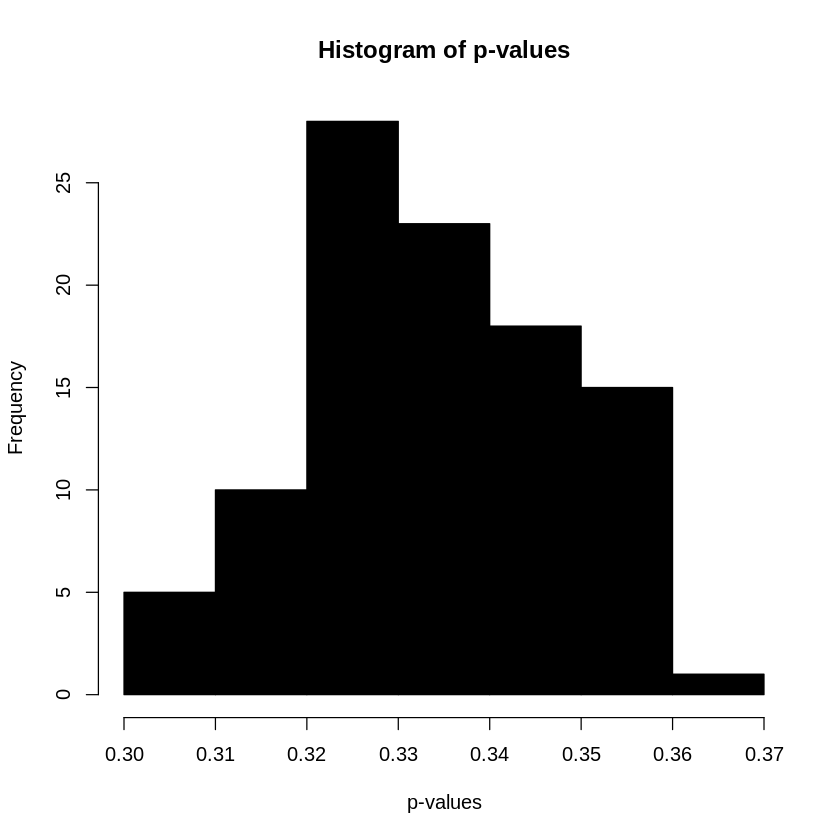

In [ ]:
# Power Test Method 1 (via randomiztion inference)

purchase_group_ate <- clean_dt[, .(mean_purchase_intent = mean(purchase_treat)), keyby = treated][,diff(mean_purchase_intent)]

purchase_intent_ri_distribution <- replicate(10000, clean_dt[ , .(mean_purchase_intent = mean(purchase_treat)), keyby = .(sample(treated))][ ,diff(mean_purchase_intent)])

purchase_intent_p_value <- mean(abs(purchase_intent_ri_distribution) > abs(purchase_group_ate))


get_p_values <- function(){
  p_values <- NA
  for (i in 1:100){
    purchase_intent_ri_distribution <- replicate(1000, clean_dt[ , .(mean_purchase_intent = mean(purchase_treat)), keyby = .(sample(treated))][ ,diff(mean_purchase_intent)])
    purchase_intent_p_value <- mean(abs(purchase_intent_ri_distribution) > abs(purchase_group_ate))
    p_values[i] <- purchase_intent_p_value
  }
  return (p_values)
}


p_values <- get_p_values()

hist(
  x = p_values, 
  col = 'black', 
  main = 'Histogram of p-values', 
  xlab = 'p-values')

mean(p_values < 0.05)

In [ ]:
# Power Test Method 2 (via power t-test) # use in paper

purchase_group_ate <- clean_dt[, .(mean_purchase_intent = mean(purchase_treat)), keyby = treated][,diff(mean_purchase_intent)]
treated <- clean_dt[treated == 1, .N]
control <- clean_dt[treated == 0, .N]

pwr.t2n.test(n1 = control, n2= treated, d = purchase_group_ate, sig.level = 0.05, power = NULL)


     t test power calculation 

             n1 = 76
             n2 = 75
              d = 0.1593246
      sig.level = 0.05
          power = 0.1634094
    alternative = two.sided


# Reported Size and Self-Esteem Analysis

In [ ]:
####################
# CHI SQUARED TEST #
####################

#Using a chi squared test to test independence between size and self-esteem. 
#This is analgous to a correlation test, but since these variables are categorical, a chi-squared test is the most appropriate.

chi_sq_results <- chisq.test(table(clean_dt$size_bucket, clean_dt$self_esteem_rate))
chi_sq_results$expected #Expected frequencies table -- which resulted in the warning below, since there exist frequencies lower than 5 (threshold for this function).
chi_sq_results


Warning message in chisq.test(table(clean_dt$size_bucket, clean_dt$self_esteem_rate)):
“Chi-squared approximation may be incorrect”


,High,Low,Neutral
0-4,11.1944444,7.2222222,7.5833333
12-16,15.0694444,9.7222222,10.2083333
18+,8.1805556,5.2777778,5.5416667
26,0.4305556,0.2777778,0.2916667
6-10,27.1250000,17.5000000,18.3750000



	Pearson's Chi-squared test

data:  table(clean_dt$size_bucket, clean_dt$self_esteem_rate)
X-squared = 13.479, df = 8, p-value = 0.0964


In [ ]:
######################################
# CHI SQUARED FOLLOWUP (FISHER TEST) #
######################################

#Since the chi squared test results in expected frequencies lower than 5, we recieve the above warning. 
#As such, we follow up with a fisher test of exact counts to be sure.
#Source: https://statsandr.com/blog/chi-square-test-of-independence-in-r/#combination-of-plot-and-statistical-test
#Source: https://statsandr.com/blog/fisher-s-exact-test-in-r-independence-test-for-a-small-sample/

fisher_test_results <- fisher.test(table(clean_dt$size_bucket, clean_dt$self_esteem_rate))
fisher_test_results


	Fisher's Exact Test for Count Data

data:  table(clean_dt$size_bucket, clean_dt$self_esteem_rate)
p-value = 0.05516
alternative hypothesis: two.sided


                 size_bucket 0-4 12-16 18+ 26 6-10
self_esteem_rate                                  
High                           6    18   4  1   33
Low                           10    10   7  0   13
Neutral                       10     7   8  0   17

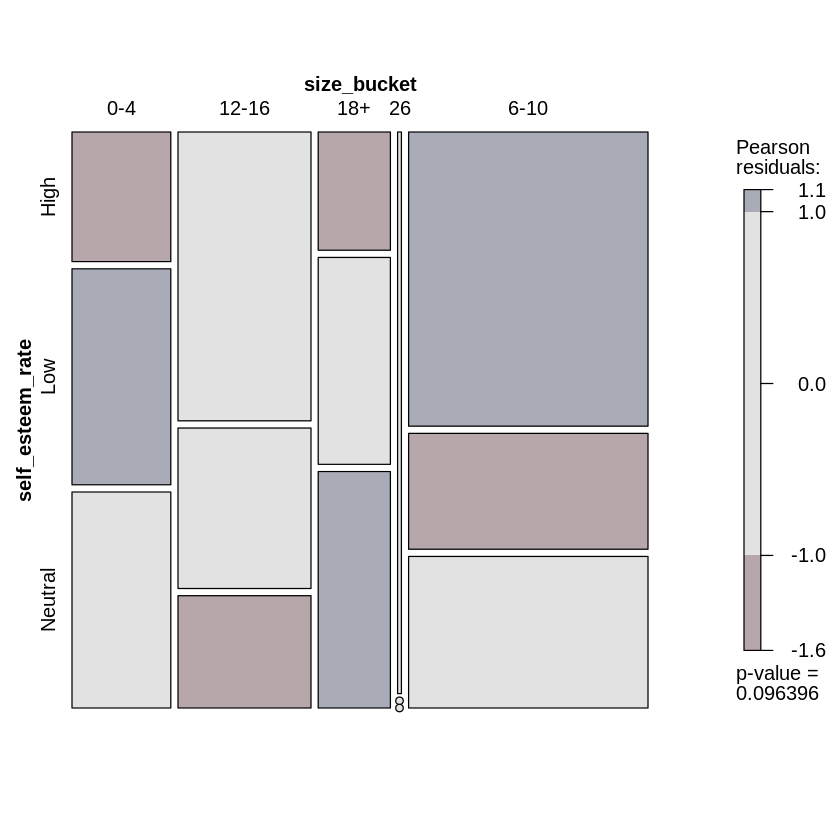

In [ ]:
# Size Bucket and Self Esteem Independence Relationship (Used instead of a correlation test, since these variables are categorial)

independence_mosaic <- mosaic(~ size_bucket + self_esteem_rate,
       direction = c("v", "h"),
       data = clean_dt,
       shade = TRUE,legend=TRUE,gp = shading_hcl, gp_args = list(interpolate = c(1, 1.6)))

independence_mosaic

In [ ]:
# Writing the transformed data table to a csv
# Delete this after final data table is created from merging the additional 50 mturk responses

# fwrite(master_df, "241_master_data.csv")

# Scratch Code

Action Items


*  Update raw data with additional 50 mechanical turk responses
*  Update the abstract to the finalized version from the writing team
*  Add any additional descriptive tables and stargazer tables we need
    
    *Not sure if this note is still relevant: Check for homoskedastic errors - not a priority 
    One model where outcome is time
    Another model with average likelihood scores
    Another model with individual outfit ATE  








In [ ]:
clean_dt[,.N, by = size_bucket]
clean_dt[,.N, by = size_free_response]
race_dt <- covariates[,.(race,treated)]
race_dt[,.N,by = .(race,treated)]

clean_dt[,.N,by = shopping_montly_amount]
#show clean_dt with condensed variables
clean_dt[,self_esteem_rate]

size_bucket,N
<chr>,<int>
6-10,47
12-16,19
0-4,20
18+,15


size_free_response,N
<chr>,<int>
8,14
12,7
"2, 4, 6",1
6,14
4,12
s,1
5,1
2,7
10,18


ERROR: ignored

In [ ]:
# Power Test Scratch

treated <- clean_dt[treated == 1, .N]
control <- clean_dt[treated == 0, .N]
smaller_group_n <- ifelse(treated < control, treated, control)
larger_group_n <- ifelse(treated < control, control, treated)
smaller_group <- ifelse(treated < control, 1, 0)
treated_sd <- clean_dt[treated == 1, sd(purchase_treat)]
control_sd <- clean_dt[treated == 0, sd(purchase_treat)]
sd_ratio <- ifelse(smaller_group == 0, control_sd, treated_sd)
smaller_sd <- ifelse(smaller_group == 0, 0, 1)
larger_sd <- ifelse(smaller_group == 0, 1, 0)
sd <- clean_dt[,sd(purchase_treat)]

In [ ]:
table(clean_dt$size_bucket, clean_dt$self_esteem_rate)


       
        High Low Neutral
  0-4      4   6      10
  12-16   11   7       1
  18+      5   4       6
  6-10    23  10      14